In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import manifold
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

tf.keras.backend.set_floatx('float64')

# Data Preprocessing

### Import Stripe 82 data

In [2]:
lcs_S = np.load('../data/SDSS/Stripe 82/lc_n50.npy')
lbs_S = np.ones((lcs_S.shape[0],), dtype=int)#np.load('../data/MANTRA/labels_n50.npy')
#lbs_S_all = np.load('../data/MANTRA/labels_all_n50.npy')
lcs_S.shape, lbs_S.shape#, lbs_S_all.shape

((8550, 50, 11), (8550,))

header: (MJD,  u, u_err,  g, g_err,  r, r_err,  i, i_err,  z, z_err)

In [3]:
lcs_S[22][:,1]

array([19.368, 19.492, 19.504, 19.325, 19.359, 19.342, 19.331, 19.292,
       19.349, 19.368, 19.518, 19.768, 19.985, 19.699, 19.687, 21.453,
       19.594, 19.666, 19.529, 19.561, 19.545, 19.549, 19.593, 19.592,
       19.484, 19.596, 19.591, 19.577, 19.547, 19.177, 19.299,    nan,
       19.279,    nan, 19.204, 19.183, 19.153,    nan, 19.194, 19.303,
       19.183, 19.22 ,    nan, 19.301, 19.231,    nan, 19.195, 19.277,
          nan, 19.262])

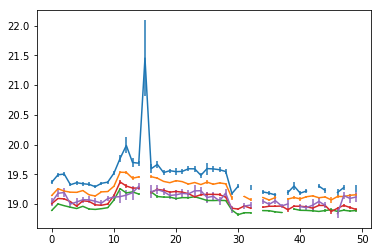

In [4]:
index = 22;
for i in range(1,10,2):
    plt.errorbar(x=range(50),#lcs_S[index,:,0],
                 y=lcs_S[index,:,i], yerr=lcs_S[index,:,i+1])

### Mask NANs

In [5]:
lcs_S[0,:,-2]

array([20.161, 19.808, 20.019, 20.123, 20.045, 20.013, 19.89 , 19.849,
       20.04 , 20.392, 20.367, 19.758, 20.055, 20.324, 19.93 , 19.867,
       20.107, 19.983, 19.829, 20.031, 19.84 , 19.98 , 20.143, 20.033,
       19.854, 19.985, 19.951, 20.003, 20.061, 20.271, 20.451, 19.941,
       20.292, 20.059, 20.227, 20.434, 20.011,    nan, 20.332,    nan,
          nan,    nan, 19.971,    nan, 20.174,    nan, 19.711, 20.101,
       20.025, 20.046])

In [6]:
mask_S = np.ma.masked_invalid(lcs_S).mask
mask_S.shape

(8550, 50, 11)

### Import MANTRA data

In [7]:
lcs_M = np.load('../data/MANTRA/lc_n50.npy')
lbs_M = np.load('../data/MANTRA/labels_n50.npy')
lbs_M_all = np.load('../data/MANTRA/labels_all_n50.npy')
lcs_M.shape, lbs_M.shape, lbs_M_all.shape

((1436, 50, 3), (1436,), (1436,))

header: (Mag, Magerr, MJD)

In [163]:
def times_to_lags(T):
    """
    (N x n_step) matrix of times -> (N x n_step) matrix of lags.
    First time is assumed to be zero.
    **From keras_utils**
    """
    assert T.ndim == 2, "T must be an (N x n_step) matrix"
    return np.c_[np.zeros(T.shape[0]), np.diff(T, axis=1)]

def lags_to_times(dT):
    """(N x n_step) matrix of lags -> (N x n_step) matrix of times
    First time is assumed to be zero.
    """
    assert dT.ndim == 2, "dT must be an (N x n_step) matrix"
    return np.cumsum(dT[:,:], axis=1)

In [10]:
def preprocess_MANTRA(X_raw, Y_raw, test_size=0.2, random_state=0):
    """
    Apply times_to_lags(MJD)
    Center/Normalize  Mag with StandardScaler
    Normalize Magerr
    **from tachibana github**
    """
    X=X_raw.copy()
    # MJD -> d(MJD)
    X[:,:,2] = times_to_lags(X[:,:,2])
    
    scaler = StandardScaler()
    # mag -> (mag - mag.mean)/mag.std
    X[:,:,0] = scaler.fit_transform(X[:,:,0].T).T
    # magerr -> magerr/mag.std
    X[:,:,1] = np.transpose(X[:,:,1].T / scaler.scale_)
    # peel off magerr as separate array: X[d(MJD), mag_scaled]
    #X = X[:,:,[2,0]]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                        Y_raw,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                       )
    data = [X_train[:,:,[2,0]], X_test[:,:,[2,0]], Y_train, Y_test]
    errors = [X_train[:,:,1], X_test[:,:,1]]
    
    return data, errors, scaler

In [6]:
data, errors, scaler = preprocess_MANTRA(lcs_M, lbs_M)
X_train, X_test, Y_train, Y_test = data

main_input = layers.Input(shape=(X_train.shape[1], 2), name='main_input') # (lag, mag)
aux_input = layers.Input(shape=(X_train.shape[1], 1), name='aux_input') # (lag)
model_input = [main_input, aux_input]

In [8]:
data = [X_train, X_test, Y_train, Y_test]

In [9]:
errors[0].shape

(1148, 50)

<br><br><br>

In [11]:
def preprocess_S82(X_raw, Y_raw, test_size=0.2, random_state=0):
    """
    Apply times_to_lags(MJD)
    Center/Normalize  Mags with StandardScaler
    Normalize Magerrs
    """
    X=X_raw.copy()
    # MJD -> d(MJD)
    X[:,:,0] = times_to_lags(X[:,:,0])
    
    scaler = StandardScaler()
    for i in range(1,10,2):
        # mag -> (mag - mag.mean)/mag.std
        X[:,:,i] = scaler.fit_transform(X[:,:,i].T).T
        # magerr -> magerr/mag.std
        X[:,:,i+1] = np.transpose(X[:,:,i+1].T / scaler.scale_)

    
    X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                        Y_raw,
                                                        test_size=test_size,
                                                        random_state=random_state
                                                       )
    data = [X_train[:,:,[0,1,3,5,7,9]], X_test[:,:,[0,1,3,5,7,9]], Y_train, Y_test]
    errors = [X_train[:,:,[2,4,6,8,10]], X_test[:,:,[2,4,6,8,10]]]
    
    return data, errors, scaler

In [102]:
data, errors, scaler = preprocess_S82(lcs_S, lbs_S)
X_train, X_test, Y_train, Y_test = data
X_train_mask, X_test_mask, Y_train_mask, Y_test_mask = list(map(lambda x: ~np.ma.masked_invalid(x).mask, data))

# Apply nan masks, setting nans to 0.
X_train = np.where(X_train_mask, X_train, 0.)
X_test = np.where(X_test_mask, X_test, 0.)

main_input = layers.Input(shape=(X_train.shape[1], 6), name='main_input') # (lag, mag-ugriz)
aux_input = layers.Input(shape=(X_train.shape[1], 1), name='aux_input') # (lag)
model_input = [main_input, aux_input]

In [103]:
X_train.shape, X_train_mask.shape

((6840, 50, 6), (6840, 50, 6))

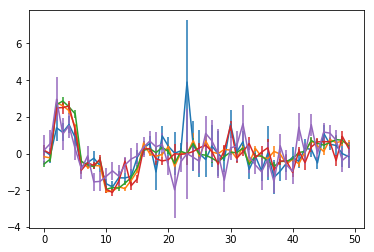

In [104]:
index = 6;
for i in range(1,6):
    plt.errorbar(x=range(50),#lags_to_times(X_train[index:index+1,:,0])[0],
                 y=X_train[index,:,i], yerr=errors[0][index,:,i-1])

<br><br><br>
# Network Architecture

In [108]:
encode = main_input
encode = layers.LSTM(50, return_sequences=True)(encode)
encode = layers.Dropout(0.25)(encode)
encode = layers.LSTM(50, return_sequences=False)(encode)
encode = layers.Dense(50, activation='linear')(encode)

decode = layers.RepeatVector(50)(encode)
decode = layers.Concatenate(axis=2)([aux_input, decode])
decode = layers.LSTM(50, return_sequences=True)(decode)
decode = layers.Dropout(0.25)(decode)
decode = layers.LSTM(50, return_sequences=True)(decode)
decode = layers.TimeDistributed(layers.Dense(1, activation='linear'), name='decoder')(decode)

classify = layers.Dense(16, activation='relu')(encode)
classify = layers.Dense(1, activation='sigmoid', name='classifier')(classify)

model = Model(inputs=model_input, outputs=[decode, classify]) #classify, 

# Define losses/lossWeights for the two outputs of the model
losses = {
    'decoder': 'mse'#,
    #'classifier': 'binary_crossentropy'
}
lossWeights = {'decoder': 1.0}#, 'classifier': 1.0}

model.compile(optimizer=Adam(),
              loss=losses,
              loss_weights=lossWeights,
              #metrics={'classifier': 'accuracy'},
              #sample_weight_mode='temporal',
             )

#sample_weights = 1./errors[0]

In [18]:
np.expand_dims(sample_weights,2).shape

(6840, 50, 1, 5)

In [366]:
np.reshape(sample_weights, (1148, 50,1)).shape

(1148, 50, 1)

In [109]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 50, 6)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 50, 50)       11400       main_input[0][0]                 
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 50, 50)       0           lstm_8[0][0]                     
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 50)           20200       dropout_4[0][0]                  
____________________________________________________________________________________________

In [117]:
history = model.fit(x={'main_input': X_train, 'aux_input': np.delete(X_train, range(1,6), axis=2)},
                    y={'decoder': X_train[:,:,[1]]},#, 'classifier': Y_train},
                    epochs=5,
                    batch_size=32,
                    #sample_weight={'decoder': np.reshape(sample_weights, (1148, 50))},#np.expand_dims(sample_weights,2)},
                    shuffle=True,
                    validation_data=({'main_input': X_test, 'aux_input': np.delete(X_test, range(1,6), axis=2)}, {'decoder': X_test[:,:,[1]] }))#, 'classifier': Y_test}))

Train on 6840 samples, validate on 1710 samples
Epoch 1/5
6840/6840 [==============================] - 37s 5ms/sample - loss: 0.4114 - decoder_loss: 0.4114 - val_loss: 0.3989 - val_decoder_loss: 0.4000
Epoch 2/5
6840/6840 [==============================] - 37s 5ms/sample - loss: 0.4078 - decoder_loss: 0.4078 - val_loss: 0.3960 - val_decoder_loss: 0.3971
Epoch 3/5
6840/6840 [==============================] - 37s 5ms/sample - loss: 0.4037 - decoder_loss: 0.4037 - val_loss: 0.3872 - val_decoder_loss: 0.3883
Epoch 4/5
6840/6840 [==============================] - 37s 5ms/sample - loss: 0.4003 - decoder_loss: 0.4003 - val_loss: 0.3985 - val_decoder_loss: 0.3995
Epoch 5/5
6840/6840 [==============================] - 37s 5ms/sample - loss: 0.3966 - decoder_loss: 0.3965 - val_loss: 0.3819 - val_decoder_loss: 0.3830


Text(0.5,1,'Loss')

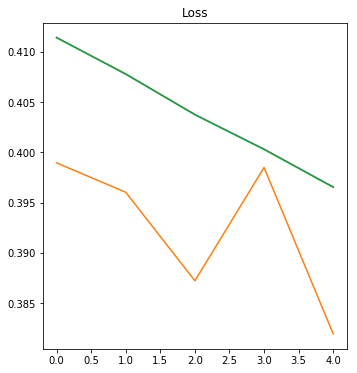

In [119]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.plot(history.history['decoder_loss'][:])
#plt.plot(history.history['classifier_loss'][2:])
plt.title('Loss')

#plt.subplot(1,2,2)
#plt.plot(history.history['classifier_accuracy'][2:]);
#plt.plot(history.history['val_classifier_accuracy'][2:]);
#plt.title('Accuracy');

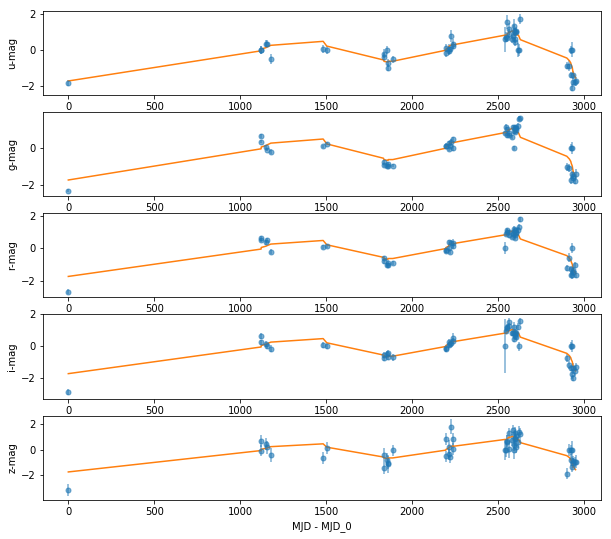

In [184]:
src_i = 5;

N_bands = 5; bands = ['u','g','r','i','z']

plt.figure(figsize=(10,9))
for ind in range(N_bands):
    band_i = ind+1
    t = lags_to_times(X_train[src_i:src_i+1][:,:,0])[0]
    plt.subplot(N_bands,1,band_i)
    plt.errorbar(t, X_train[src_i,:,band_i], yerr=errors[0][src_i,:,band_i-1], marker='.', ms=10, ls='none', alpha=.6)
    plt.plot(t, model.predict({'main_input': X_train[src_i:src_i+1], 'aux_input': X_train[src_i:src_i+1,:,0:1]})[0][0])#np.delete(X_train[index:index+1], [1,2,3,4,5], axis=2)})[0][0])
    plt.ylabel(bands[band_i-1]+'-mag');
#    plt.title('class:'+str(Y_train[i]))
plt.xlabel('MJD - MJD_0');

<br><br><br><br><br><br><br><br><br>
### Previous Results

In [14]:
history = model.fit(x={'main_input': X_train, 'aux_input': np.delete(X_train, 1, axis=2)},
                    y={'decoder': X_train[:,:,[1]], 'classifier': Y_train},
                    epochs=30,
                    batch_size=32,
                    #sample_weight={'decoder': np.reshape(sample_weights, (1148, 50))},#np.expand_dims(sample_weights,2)},
                    shuffle=True,
                    validation_data=({'main_input': X_test, 'aux_input': np.delete(X_test, 1, axis=2)}, {'decoder': X_test[:,:,[1]], 'classifier': Y_test}))

Train on 1148 samples, validate on 288 samples
Epoch 1/30
1148/1148 [==============================] - 19s 16ms/sample - loss: 1.5644 - decoder_loss: 0.9752 - classifier_loss: 0.5894 - classifier_accuracy: 0.7247 - val_loss: 1.5195 - val_decoder_loss: 0.9554 - val_classifier_loss: 0.5641 - val_classifier_accuracy: 0.7222
Epoch 2/30
1148/1148 [==============================] - 8s 7ms/sample - loss: 1.4783 - decoder_loss: 0.9530 - classifier_loss: 0.5255 - classifier_accuracy: 0.7308 - val_loss: 1.4760 - val_decoder_loss: 0.9393 - val_classifier_loss: 0.5367 - val_classifier_accuracy: 0.7222
Epoch 3/30
1148/1148 [==============================] - 8s 7ms/sample - loss: 1.4433 - decoder_loss: 0.9338 - classifier_loss: 0.5104 - classifier_accuracy: 0.7596 - val_loss: 1.4712 - val_decoder_loss: 0.9198 - val_classifier_loss: 0.5514 - val_classifier_accuracy: 0.7569
Epoch 4/30
1148/1148 [==============================] - 8s 7ms/sample - loss: 1.4143 - decoder_loss: 0.9189 - classifier_loss: 0.

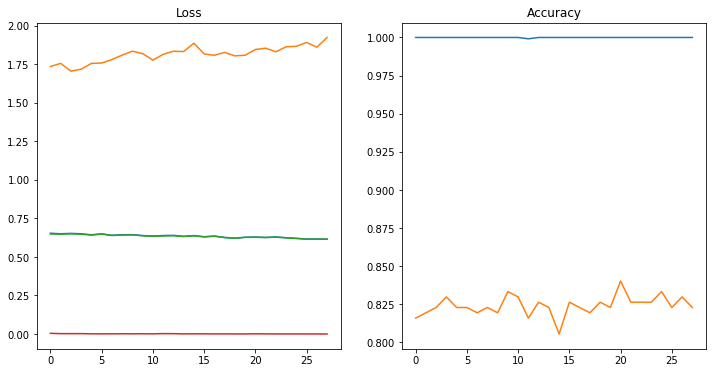

In [461]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['decoder_loss'][2:])
plt.plot(history.history['classifier_loss'][2:])
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['classifier_accuracy'][2:]);
plt.plot(history.history['val_classifier_accuracy'][2:]);
plt.title('Accuracy');

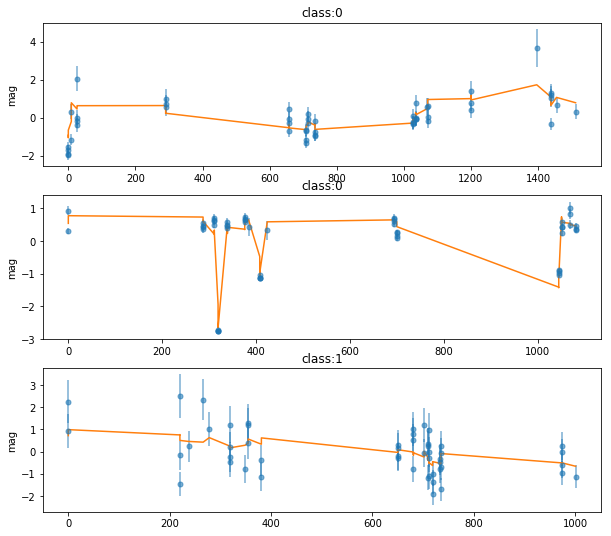

In [462]:
index = 2;

plt.figure(figsize=(10,9))
for ind in range(3):
    i = ind+index
    t = lags_to_times(X_train[i:i+1][:,:,0])[0]
    plt.subplot(3,1,ind+1)
    plt.errorbar(t, X_train[i,:,1], yerr=errors[0][i], marker='.', ms=10, ls='none', alpha=.6)
    plt.plot(t, model.predict({'main_input': X_train[i:i+1], 'aux_input': np.delete(X_train[i:i+1], 1, axis=2)})[0][0])
    plt.ylabel('mag');
    plt.title('class:'+str(Y_train[i]))

<br><br><br>
# t-SNE

In [439]:
encoder = Model(inputs=main_input, outputs=encode)

N = 1436;   # Number of examples

# Generate encodings
encoded_2_train = encoder.predict({'main_input': X_train[:N], 'aux_input': np.delete(X_train[:N], 1, axis=2)})
encoded_2_test = encoder.predict({'main_input': X_test[:N], 'aux_input': np.delete(X_test[:N], 1, axis=2)})

Ntrain = encoded_2_train.shape[0]
#Ntest = encoded_2_test.shape[0]

encoded_2_train.shape, encoded_2_test.shape, np.r_[encoded_2_train,encoded_2_test].shape

((1148, 50), (288, 50), (1436, 50))

In [285]:
%%time
tsne = manifold.TSNE(n_components=2,
                     perplexity=400,
                     learning_rate=200,
                     n_iter=400,
                     init='pca',
                     random_state=0)

both_sets = np.r_[encoded_2_train, encoded_2_test]

tsned = tsne.fit_transform(both_sets)
#test_2_tsne = tsne.fit_transform(encoded_2_test)

tsned.shape

Wall time: 21.9 s


(1436, 2)

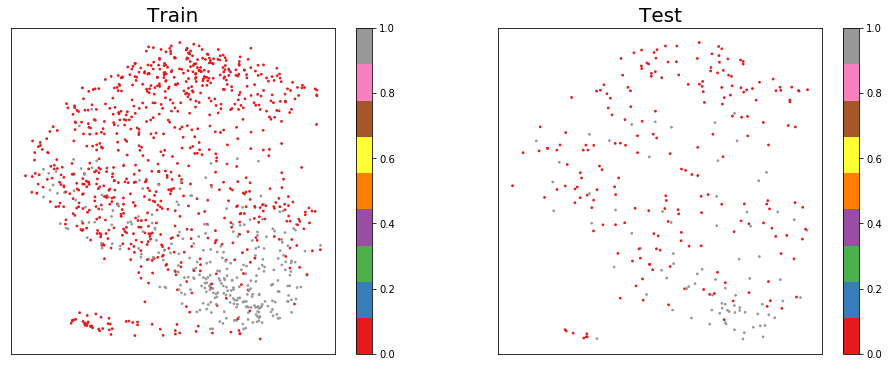

In [286]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(tsned[:Ntrain,0], tsned[:Ntrain,1], s=3, c=Y_train, cmap='Set1')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(1,2,2)
plt.scatter(tsned[Ntrain:,0], tsned[Ntrain:,1], s=3, c=Y_test, cmap='Set1')
plt.colorbar()
ax.set_title('Test', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

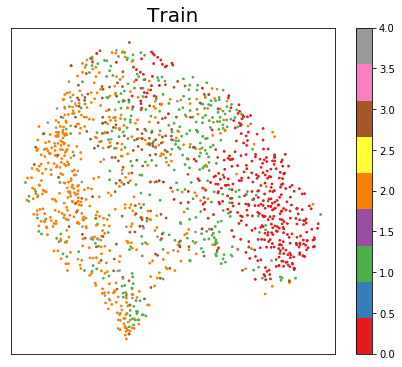

In [247]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1,2,1)
plt.scatter(train_2_tsne[:,0], train_2_tsne[:,1], s=3, c=lbs_all[:N], cmap='Set1')
plt.colorbar()
ax.set_title('Train', fontsize=20)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [455]:
def tsne_plot(perplexity, n_iter, Ntrain, Ntest, data, main_input, encode, ):
    """
    
    """
    
    encoder = Model(inputs=main_input, outputs=encode)
    X_train, X_test, Y_train, Y_test = data # Unpack train/test data
    
# Generate encodings
    encoded_2_train = encoder.predict({'main_input': X_train[:Ntrain],
                                       'aux_input': np.delete(X_train[:Ntrain], 1, axis=2)})
    encoded_2_test = encoder.predict({'main_input': X_test[:Ntest],
                                      'aux_input': np.delete(X_test[:Ntest], 1, axis=2)})
    
    tsne = manifold.TSNE(n_components=2,
                         perplexity=perplexity,
                         learning_rate=200,
                         n_iter=n_iter,
                         init='pca',
                         random_state=0)
    
    both_sets = np.r_[encoded_2_train, encoded_2_test]
    tsned = tsne.fit_transform(both_sets)
    
    plt.figure(figsize=(16,6))
    ax = plt.subplot(1,2,1)
    plt.scatter(tsned[:Ntrain,0], tsned[:Ntrain,1], s=3, c=Y_train[:Ntrain], cmap='Paired')
    plt.colorbar()
    ax.set_title('Train, Perp: '+str(perplexity), fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1,2,2)
    plt.scatter(tsned[Ntrain:,0], tsned[Ntrain:,1], s=3, c=Y_test[:Ntest], cmap='Paired')
    plt.colorbar()
    ax.set_title('Test, Perp: '+str(perplexity), fontsize=20)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

Wall time: 6.77 s


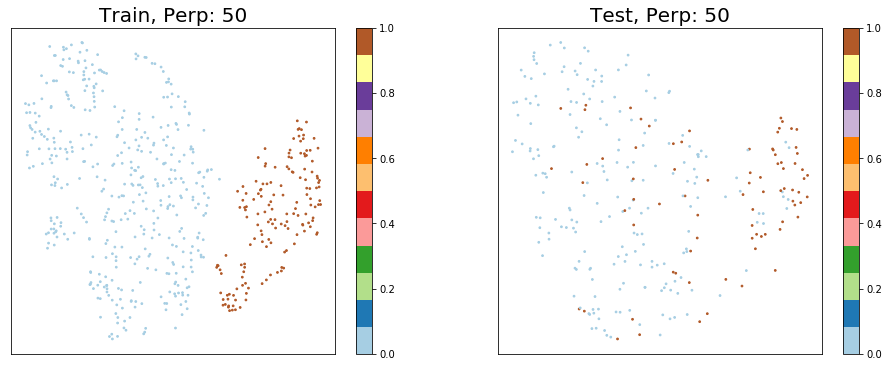

In [463]:
%%time
tsne_plot(perplexity=50,
            n_iter=400,
              Ntrain=int(X_train.shape[0]/2),
              Ntest=X_test.shape[0],
              data=data,
              main_input=main_input,
              encode=encode,
             )

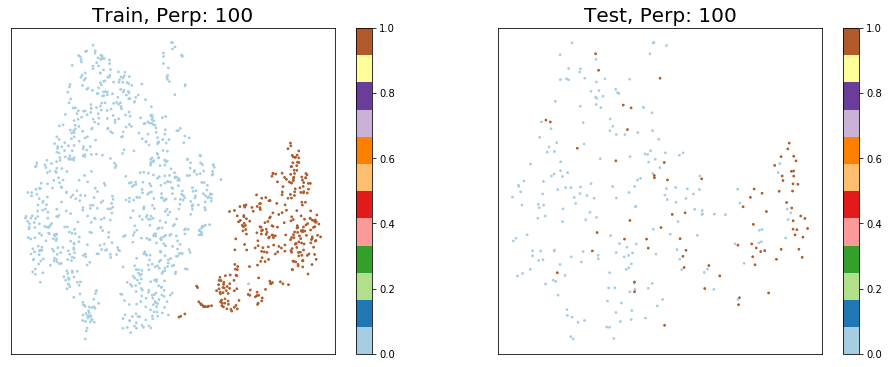

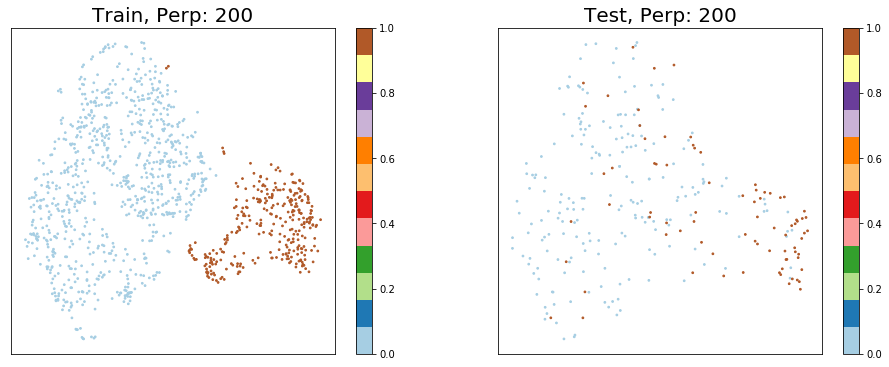

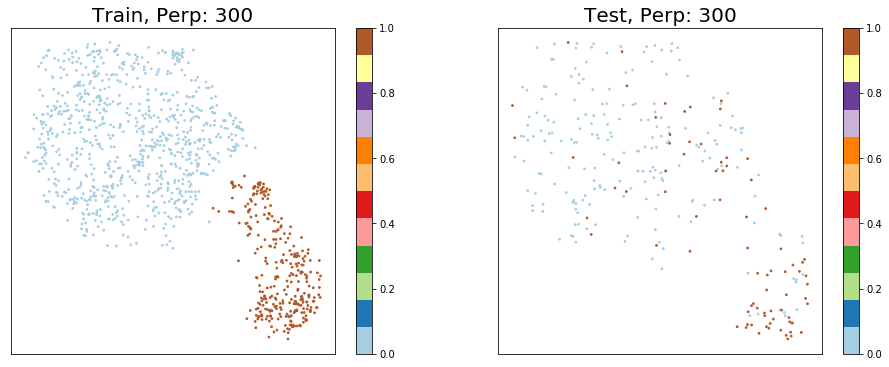

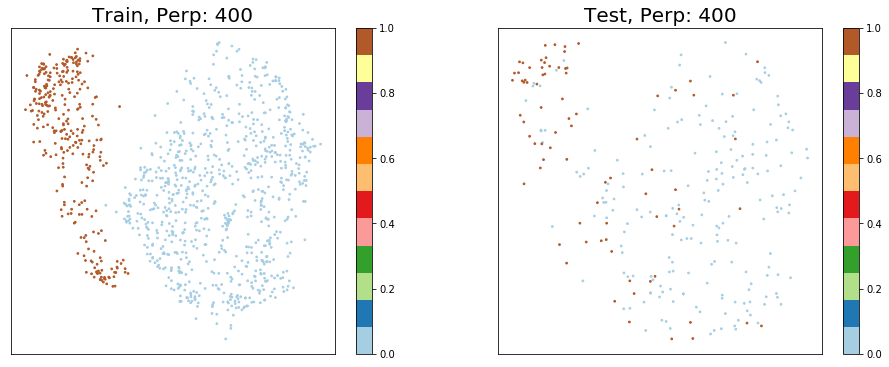

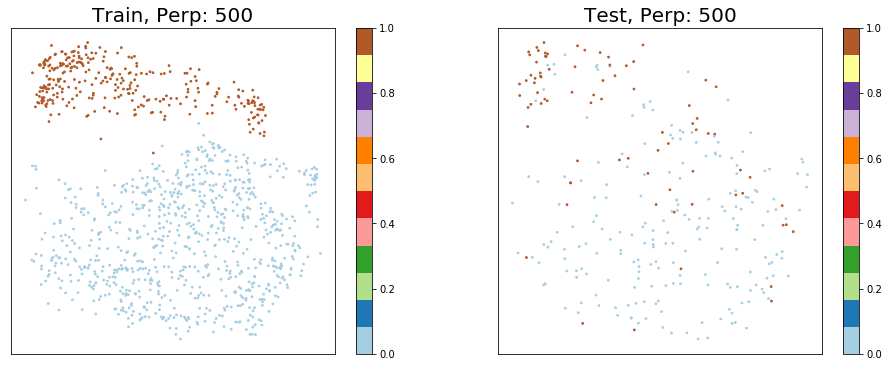

In [464]:
for perp in range(100,501,100):
    tsne_plot(perplexity=perp,
              n_iter=400,
              Ntrain=int(X_train.shape[0]/1),
              Ntest=X_test.shape[0],
              data=data,
              main_input=main_input,
              encode=encode,
             )